In [115]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import itertools
from tqdm.notebook import tqdm
from glob import glob
from scipy.stats import norm
from scipy.special import softmax
from datetime import datetime, time

from model import baseline
from model.helpers import square_exponential_kernel, normalize_last_dim
from plot import plot
from data.data_path import data_path

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

# from model.ball_base_model import *
from scripts.compute_transition_matrices import plot_transition_matrix

In [117]:
def load_data(u):

    file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]

    df = pd.read_csv(file, index_col=0)
    df.dt = pd.to_datetime(df.dt, utc=False, format="ISO8601")
    df.dt = df.dt.dt.tz_convert("Europe/London")

    all_pos = df.step_midnight.values

    min_date = df.dt.min().date()
    days = np.asarray([(dt.date() - min_date).days for dt in df.dt])
    uniq_days = np.unique(days)
    all_timestamp = (
        np.asarray(
            [
                (dt - datetime.combine(dt, time.min, dt.tz)).total_seconds()
                for dt in df.dt
            ]
        )
        / 86400
    )  # in fraction of day (between 0 and 1)

    # List of step events for each day, the event itself being the timestamp of the step
    step_events = [[] for _ in range(uniq_days.size)]

    for idx_day, day in enumerate(uniq_days):
        is_day = days == day
        obs_timestamp, obs_pos = all_timestamp[is_day], all_pos[is_day]

        # Sort the data by timestamp
        idx = np.argsort(obs_timestamp)
        obs_timestamp, obs_pos = obs_timestamp[idx], obs_pos[idx]

        # Compute the number of steps between each observed timestamp
        diff_obs_pos = np.diff(obs_pos)

        for ts, dif in zip(obs_timestamp, diff_obs_pos):
            # TODO: In the future, we probably want to spread that
            #  over a period assuming something like 6000 steps per hour
            step_events[idx_day] += [ts for _ in range(dif)]

    return step_events

In [118]:
user = "11AV"  # Select the user to use
bkp_folder = f"../../bkp/compute_transition_matrices/{user}*"

# jitter = np.finfo(np.float64).tiny

In [129]:
# ------------------------------------------------------------------------
# Compute cumulative step number and its derivative
# ------------------------------------------------------------------------

# Define the number of timesteps
n_timestep = 9

# Load data
step_events = load_data(user)

n_days = len(step_events)

timestep = np.linspace(0, 1, n_timestep+1)
X_train = []
y_train = []
deriv_cum_steps = np.zeros((n_days, timestep.size))
for idx_day in range(n_days):
    cum_steps_day = np.sum(step_events[idx_day] <= timestep[:, None], axis=1)
    deriv_cum_steps_day =  np.gradient(cum_steps_day, timestep+1) / (timestep.size)
    deriv_cum_steps[idx_day] = deriv_cum_steps_day
    for i, x in enumerate(timestep[:-1]):
        y = deriv_cum_steps_day[i]+1e-16
        
        print(y)
        X_train.append(x)
        y_train.append(np.log(y))
    
sum_steps = np.sum(deriv_cum_steps, axis=1)
print(f"{np.max(sum_steps):.02f} +/= {np.std(sum_steps):.02f}")


1e-16
1e-16
1e-16
1e-16
14.399999999999995
659.2500000000016
644.8500000000016
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
587.6999999999997
617.3999999999992
505.7999999999993
476.0999999999999
306.8999999999998
0.8999999999999998
0.44999999999999996
1.8881784197001253e-16
349.64999999999947
358.64999999999986
13.500000000000046
4.499999999999955
1e-16
1e-16
1e-16
1e-16
1e-16
2.6999999999999957
332.54999999999984
329.84999999999957
380.2499999999994
380.2499999999999
1e-16
1e-16
1e-16
1e-16
1e-16
268.6499999999999
268.6499999999996
671.8499999999989
742.4999999999998
70.65
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
103.50000000000027
2026.799999999997
1923.2999999999993
1146.5999999999997
1e-16
1e-16
1e-16
12.59999999999998
404.99999999999983
1714.500000000003
2527.650000000001
1458.8999999999996
253.35
1e-16
1e-16
1e-16
1e-16
8.999999999999996
8.999999999999988
973.7999999999984
989.0999999999997
15.3
1e-16
1e-16
1e-16
1e-16
1410.7499999999995
1598.84

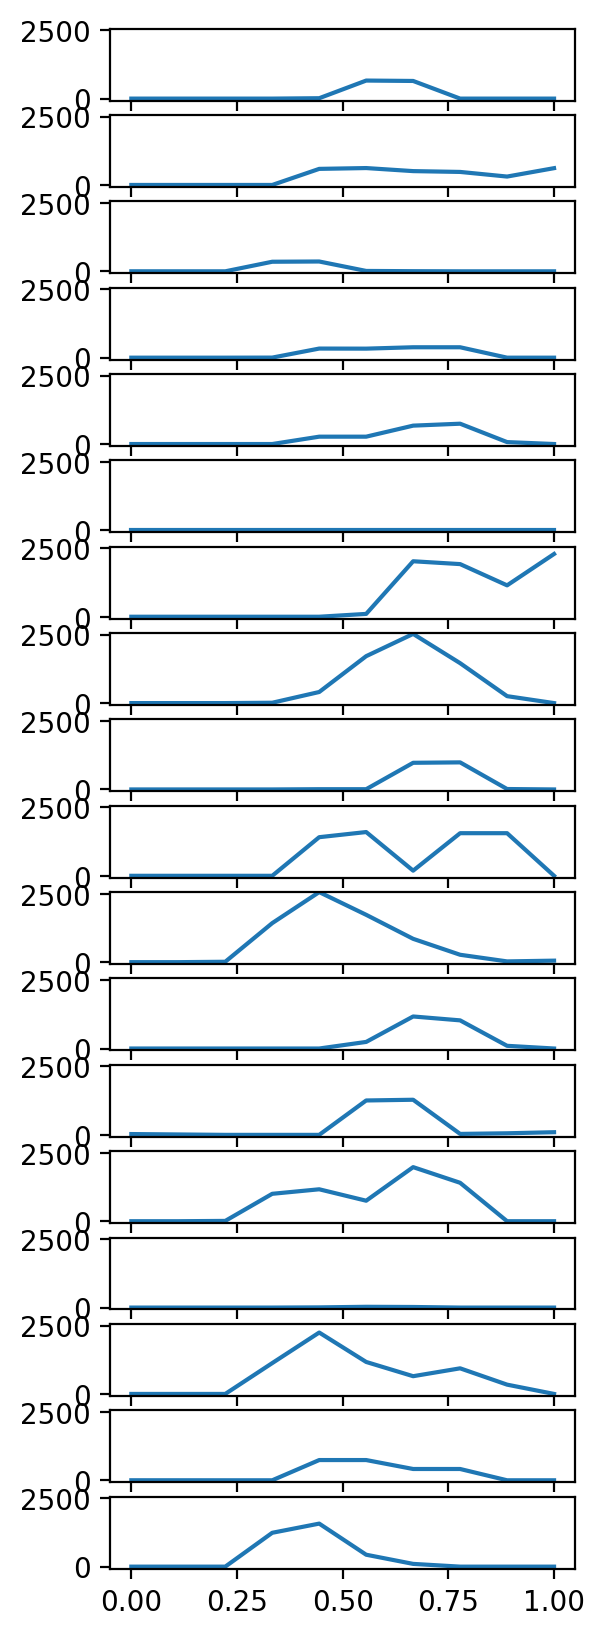

In [130]:
fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [135]:
# Normalize the data
X_train = np.asarray(X_train).reshape(-1, 1)
y_train = np.asarray(y_train)
x_scaler, y_scaler = StandardScaler(), StandardScaler()
X_train = x_scaler.fit_transform(X_train)
# y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
# X_test = scaler.transform(X_test)
# X_to_predict = scaler.transform(X_to_predict)

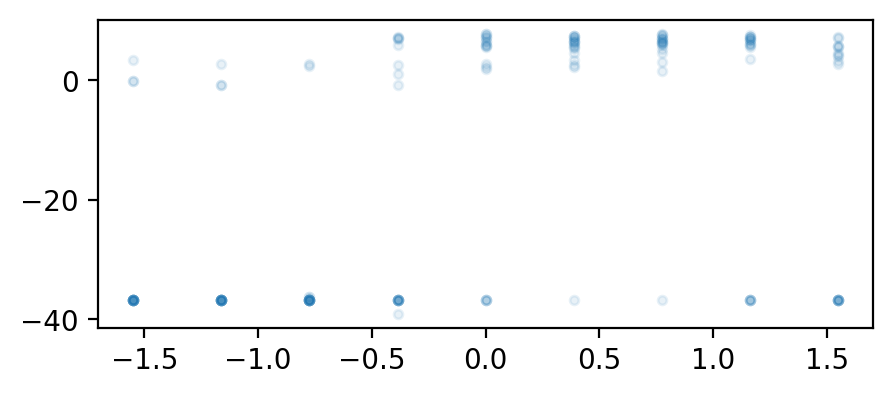

In [139]:

fig, ax = plt.subplots(figsize=(5, 2))
ax.scatter(X_train.flatten(), y_train, color="C0", alpha=0.1, s=10)

In [107]:
# Existing kernel
# kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-10, 1e10))

# Add Matern Kernel
# kernel = Matern(length_scale=2, length_scale_bounds=(1e-10, 1e10), nu=1.5)

# Add ConstantKernel
#kernel *= ConstantKernel(constant_value=1.0, constant_value_bounds=(0.1, 1e10))

# Add RationalQuadratic Kernel
kernel = Matern(length_scale=2, length_scale_bounds=(1e-10, 1e10), nu=1.5) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))


# * ConstantKernel(constant_value=1.0, constant_value_bounds=(0.1, 1e10)

# Add WhiteKernel
# kernel += WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))

# Add ConstantKernel
# kernel *= ConstantKernel(constant_value=1.0, constant_value_bounds=(0.1, 1e10))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X_train, y_train)
print(gp.kernel_)

Matern(length_scale=4.69e+06, nu=1.5) + WhiteKernel(noise_level=568)


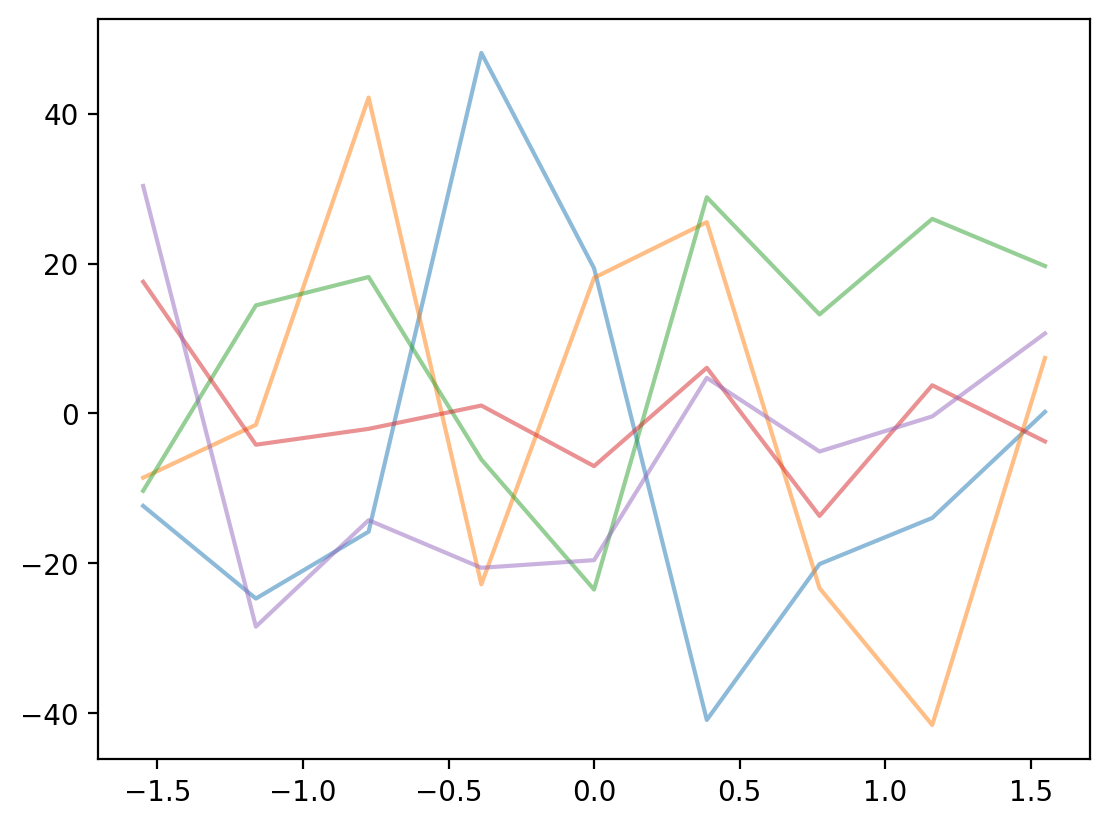

In [112]:
# Define the points where we want to sample from the posterior
# X = np.linspace(0, 5, 100).reshape(-1, 1)
X_ = timestep[:-1].reshape(-1, 1)
X = scaler.transform(X_)

# Draw samples from the posterior at the given points
y_samples = gp.sample_y(X, n_samples=5, random_state=5)

# Plot the samples
for idx, sample in enumerate(y_samples.T):
    plt.plot(X, sample, alpha=0.5, color=f"C{idx}")
plt.show()

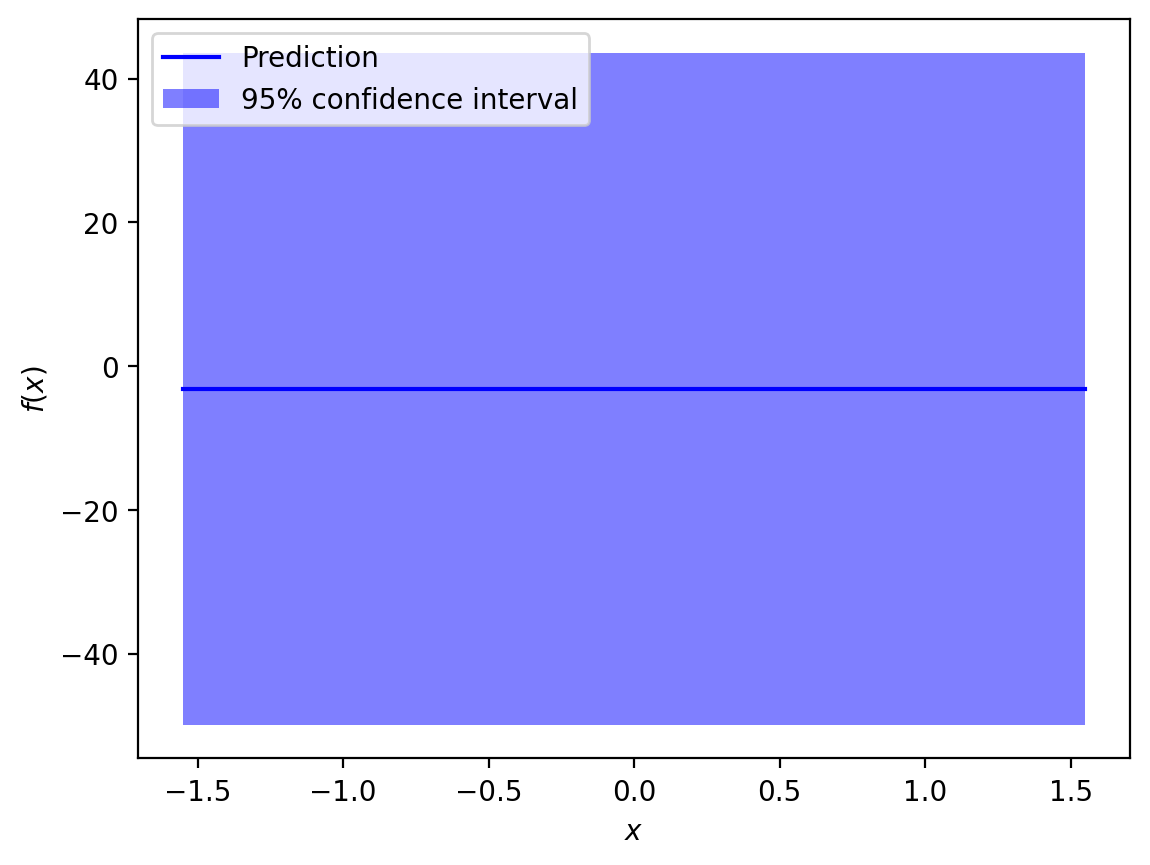

In [110]:
y_pred, sigma = gp.predict(X, return_std=True)

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.plot(X, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([X, X[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
# plt.scatter(X, y, c='r', label='Observations')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')

In [113]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import numpy as np

# Assume X is your feature matrix and y is your target matrix
X = np.random.rand(100, 3)  # 100 samples, 3 input features each
y = np.random.rand(100, 2)  # 100 samples, 2 output features each

# Kernel for the GP
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Create a GaussianProcessRegressor object
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)

# Fit to data
gp.fit(X, y)

# Predict
X_test = np.random.rand(10, 3)  # 10 test samples
y_pred = gp.predict(X_test)

print(y_pred)  # predicted values for the 2 output features

[[0.55743891 0.49247938]
 [0.55737849 0.49260994]
 [0.55750798 0.49240301]
 [0.55736369 0.49247017]
 [0.55748317 0.49262739]
 [0.55750691 0.49264168]
 [0.55746764 0.49252903]
 [0.55751281 0.4924792 ]
 [0.55743002 0.49278896]
 [0.55737992 0.49245562]]


/Users/aureliennioche/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
